In [ ]:
# Install required libraries
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:


# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score

# Load a small dataset (e.g., IMDB)
dataset = load_dataset("imdb", split="train[:1000]")

# Split the dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

# Tokenize and format the dataset
def tokenize_and_format(examples):
    tokenized = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    tokenized["labels"] = examples["label"]
    return tokenized

tokenized_dataset = dataset.map(tokenize_and_format, batched=True, remove_columns=dataset["train"].column_names)
tokenized_dataset.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_dataset["test"], batch_size=8)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Evaluation
    model.eval()
    total_preds = []
    total_labels = []
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        total_preds.extend(predictions.cpu().numpy())
        total_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(total_labels, total_preds)
    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    print(f"Validation Accuracy: {accuracy:.4f}")


print(f"Number of trainable parameters: {count_parameters(model)}")

Epoch 1/3 completed
Validation Accuracy: 1.0000
Epoch 2/3 completed
Validation Accuracy: 1.0000
Epoch 3/3 completed
Validation Accuracy: 1.0000
Number of trainable parameters: 109483778


#Regularization

In [ ]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Load a small dataset (e.g., IMDB)
dataset = load_dataset("imdb", split="train[:1000]")

# Split the dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and format the dataset
def tokenize_and_format(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_and_format, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_dataset["test"], batch_size=16)

# Set up optimizer with weight decay (L2 regularization)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


num_epochs = 6
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)

    # Evaluation
    model.eval()
    total_val_loss = 0
    total_preds = []
    total_labels = []
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            total_preds.extend(predictions.cpu().numpy())
            total_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(eval_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)

    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    #print(f"Validation Accuracy: {accuracy:.4f}")

print("Training finished")

# Print model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 completed
Average Training Loss: 0.0939
Average Validation Loss: 0.0068
Epoch 2/6 completed
Average Training Loss: 0.0048
Average Validation Loss: 0.0022
Epoch 3/6 completed
Average Training Loss: 0.0021
Average Validation Loss: 0.0011
Epoch 4/6 completed
Average Training Loss: 0.0012
Average Validation Loss: 0.0007
Epoch 5/6 completed
Average Training Loss: 0.0008
Average Validation Loss: 0.0005
Epoch 6/6 completed
Average Training Loss: 0.0006
Average Validation Loss: 0.0004
Training finished
Number of trainable parameters: 109483778


In [ ]:
# Install required libraries
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Load a small dataset (e.g., IMDB)
dataset = load_dataset("imdb", split="train[:1000]")

# Split the dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and format the dataset
def tokenize_and_format(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_and_format, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_dataset["test"], batch_size=16)

# Set up optimizer with weight decay (L2 regularization)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)

    # Evaluation
    model.eval()
    total_val_loss = 0
    total_preds = []
    total_labels = []
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            total_preds.extend(predictions.cpu().numpy())
            total_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(eval_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)

    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    #print(f"Validation Accuracy: {accuracy:.4f}")

print("Training finished")

# Print model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 completed
Average Training Loss: 0.1458
Average Validation Loss: 0.0049
Validation Accuracy: 1.0000
Epoch 2/3 completed
Average Training Loss: 0.0035
Average Validation Loss: 0.0019
Validation Accuracy: 1.0000
Epoch 3/3 completed
Average Training Loss: 0.0020
Average Validation Loss: 0.0012
Validation Accuracy: 1.0000
Training finished
Number of trainable parameters: 109483778


In [ ]:

# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Load a small dataset (e.g., IMDB)
dataset = load_dataset("imdb", split="train[:1000]")

# Split the dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and format the dataset
def tokenize_and_format(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_and_format, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_dataset["test"], batch_size=16)

# Set up optimizer with weight decay (L2 regularization)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)

    # Evaluation
    model.eval()
    total_preds = []
    total_labels = []
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        total_preds.extend(predictions.cpu().numpy())
        total_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(total_labels, total_preds)
    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

print("Training finished")

# Print model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")

#Entire dataset

In [ ]:
# Install required libraries
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
# Import necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Load a small dataset (e.g., IMDB)
dataset = load_dataset("imdb", split="train[:15000]")

# Split the dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and format the dataset
def tokenize_and_format(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_and_format, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_dataset["test"], batch_size=16)

# Set up optimizer with weight decay (L2 regularization)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)

    # Evaluation
    model.eval()
    total_val_loss = 0
    total_preds = []
    total_labels = []
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            total_preds.extend(predictions.cpu().numpy())
            total_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(eval_dataloader)
    accuracy = accuracy_score(total_labels, total_preds)

    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    #print(f"Validation Accuracy: {accuracy:.4f}")

print("Training finished")

# Print model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 completed
Average Training Loss: 0.2661
Average Validation Loss: 0.2565
Epoch 2/5 completed
Average Training Loss: 0.1340
Average Validation Loss: 0.2195
Epoch 3/5 completed
Average Training Loss: 0.0577
Average Validation Loss: 0.3302
Epoch 4/5 completed
Average Training Loss: 0.0354
Average Validation Loss: 0.2896
Epoch 5/5 completed
Average Training Loss: 0.0220
Average Validation Loss: 0.3110
Training finished
Number of trainable parameters: 109483778


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load a small dataset (e.g., IMDB)
dataset = load_dataset("imdb", split="train[:15000]")

# Split the dataset into train and validation sets
dataset = dataset.train_test_split(test_size=0.2)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Tokenize and format the dataset
def tokenize_and_format(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_and_format, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_dataset["test"], batch_size=16)

# Set up optimizer with weight decay (L2 regularization)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# Set up learning rate scheduler
total_steps = len(train_dataloader) * 10  # 10 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training and evaluation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
train_losses = []
val_losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Evaluation
    model.eval()
    total_val_loss = 0
    total_preds = []
    total_labels = []
    with torch.no_grad():
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            total_preds.extend(predictions.cpu().numpy())
            total_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(eval_dataloader)
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(total_labels, total_preds)
    accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    print(f"Average Training Loss: {avg_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

print("Training finished")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.close()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.close()

print("Plots saved as loss_plot.png and accuracy_plot.png")

# Print model size
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 completed
Average Training Loss: 0.2640
Average Validation Loss: 0.2125
Validation Accuracy: 0.9180
Epoch 2/10 completed
Average Training Loss: 0.1285
Average Validation Loss: 0.2035
Validation Accuracy: 0.9157
Epoch 3/10 completed
Average Training Loss: 0.0548
Average Validation Loss: 0.2495
Validation Accuracy: 0.9183
Epoch 4/10 completed
Average Training Loss: 0.0240
Average Validation Loss: 0.3174
Validation Accuracy: 0.9213
Epoch 5/10 completed
Average Training Loss: 0.0143
Average Validation Loss: 0.3397
Validation Accuracy: 0.9247
Epoch 6/10 completed
Average Training Loss: 0.0092
Average Validation Loss: 0.3865
Validation Accuracy: 0.9153
Epoch 7/10 completed
Average Training Loss: 0.0069
Average Validation Loss: 0.4028
Validation Accuracy: 0.9223
Epoch 8/10 completed
Average Training Loss: 0.0040
Average Validation Loss: 0.4331
Validation Accuracy: 0.9200
Epoch 9/10 completed
Average Training Loss: 0.0026
Average Validation Loss: 0.4394
Validation Accuracy: 0.9197
E

#Rotten_tomatoes

In [ ]:
# Install required libraries
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom pruning function
def custom_prune_model(model, amount=0.2):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            num_params = weight.numel()
            num_to_prune = int(amount * num_params)

            # Get the indices of the smallest absolute values
            _, indices = torch.topk(torch.abs(weight).flatten(), k=num_to_prune, largest=False)

            # Create a mask
            mask = torch.ones_like(weight).flatten()
            mask[indices] = 0
            mask = mask.reshape(weight.shape)

            # Apply the mask
            module.weight.data.mul_(mask)

# Prune the model
custom_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Training Loss: 0.6502
Validation Loss: 0.5634
-----------------------------
Epoch 2/3
Training Loss: 0.5263
Validation Loss: 0.4891
-----------------------------
Epoch 3/3
Training Loss: 0.4386
Validation Loss: 0.4749
-----------------------------
Training completed!
Test Accuracy: 77.11%


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.6491
Validation Loss: 0.5555
-----------------------------
Epoch 2/10
Training Loss: 0.5205
Validation Loss: 0.4911
-----------------------------
Epoch 3/10
Training Loss: 0.4366
Validation Loss: 0.4624
-----------------------------
Epoch 4/10
Training Loss: 0.3667
Validation Loss: 0.4740
-----------------------------
Epoch 5/10
Training Loss: 0.3106
Validation Loss: 0.4946
-----------------------------
Epoch 6/10
Training Loss: 0.2630
Validation Loss: 0.5197
-----------------------------
Epoch 7/10
Training Loss: 0.2156
Validation Loss: 0.5342
-----------------------------
Epoch 8/10
Training Loss: 0.1887
Validation Loss: 0.5642
-----------------------------
Epoch 9/10
Training Loss: 0.1564
Validation Loss: 0.6377
-----------------------------
Epoch 10/10
Training Loss: 0.1310
Validation Loss: 0.6546
-----------------------------
Training completed!
Test Accuracy: 78.42%


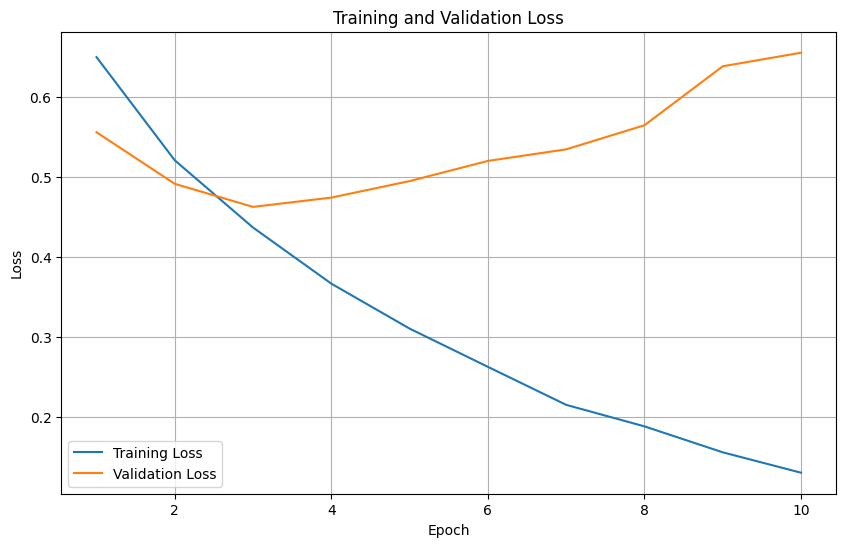

In [8]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom pruning function
def custom_prune_model(model, amount=0.2):
    for name, module in model.named_modules(): # function returns an iterator over all the modules (layers) in the model along with their names.
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            num_params = weight.numel()
            num_to_prune = int(amount * num_params)

            # Get the indices of the smallest absolute values
            _, indices = torch.topk(torch.abs(weight).flatten(), k=num_to_prune, largest=False)

            # Create a mask
            mask = torch.ones_like(weight).flatten()
            mask[indices] = 0
            mask = mask.reshape(weight.shape)

            # Apply the mask
            module.weight.data.mul_(mask)

# Prune the model
custom_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 10

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#Learning rate decresed

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
Training Loss: 0.6868
Validation Loss: 0.6647
-----------------------------
Epoch 2/10
Training Loss: 0.6441
Validation Loss: 0.5972
-----------------------------
Epoch 3/10
Training Loss: 0.5701
Validation Loss: 0.5258
-----------------------------
Epoch 4/10
Training Loss: 0.5075
Validation Loss: 0.4997
-----------------------------
Epoch 5/10
Training Loss: 0.4694
Validation Loss: 0.4961
-----------------------------
Epoch 6/10
Training Loss: 0.4341
Validation Loss: 0.4808
-----------------------------
Epoch 7/10
Training Loss: 0.3988
Validation Loss: 0.4826
-----------------------------
Epoch 8/10
Training Loss: 0.3764
Validation Loss: 0.4841
-----------------------------
Epoch 9/10
Training Loss: 0.3536
Validation Loss: 0.4861
-----------------------------
Epoch 10/10
Training Loss: 0.3238
Validation Loss: 0.4835
-----------------------------
Training completed!
Test Accuracy: 77.02%


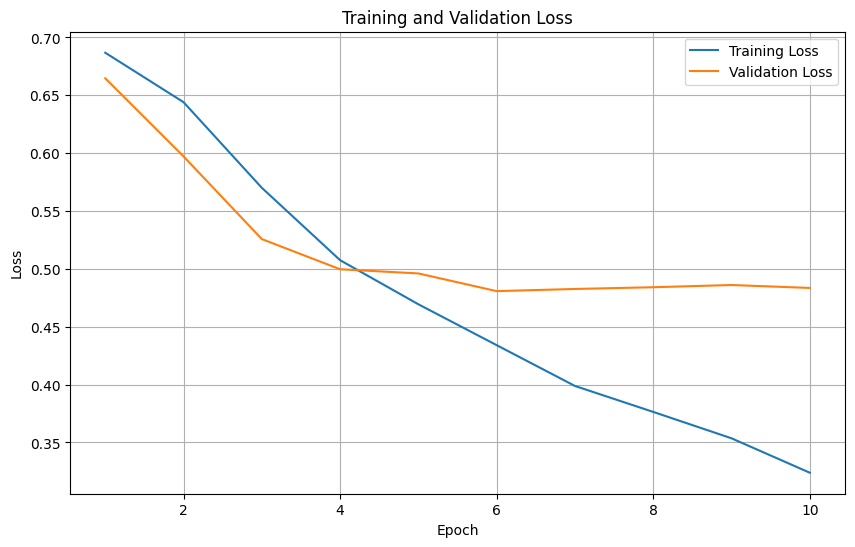

In [9]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom pruning function
def custom_prune_model(model, amount=0.2):
    for name, module in model.named_modules(): # function returns an iterator over all the modules (layers) in the model along with their names.
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            num_params = weight.numel()
            num_to_prune = int(amount * num_params)

            # Get the indices of the smallest absolute values
            _, indices = torch.topk(torch.abs(weight).flatten(), k=num_to_prune, largest=False)

            # Create a mask
            mask = torch.ones_like(weight).flatten()
            mask[indices] = 0
            mask = mask.reshape(weight.shape)

            # Apply the mask
            module.weight.data.mul_(mask)

# Prune the model
custom_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#Dropout added :model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2, hidden_dropout_prob=0.3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.6918
Validation Loss: 0.6735
-----------------------------
Epoch 2/10
Training Loss: 0.6773
Validation Loss: 0.6462
-----------------------------
Epoch 3/10
Training Loss: 0.6487
Validation Loss: 0.5996
-----------------------------
Epoch 4/10
Training Loss: 0.6088
Validation Loss: 0.5538
-----------------------------
Epoch 5/10
Training Loss: 0.5705
Validation Loss: 0.5236
-----------------------------
Epoch 6/10
Training Loss: 0.5381
Validation Loss: 0.5060
-----------------------------
Epoch 7/10
Training Loss: 0.5181
Validation Loss: 0.4959
-----------------------------
Epoch 8/10
Training Loss: 0.5004
Validation Loss: 0.4917
-----------------------------
Epoch 9/10
Training Loss: 0.4829
Validation Loss: 0.4871
-----------------------------
Epoch 10/10
Training Loss: 0.4675
Validation Loss: 0.4800
-----------------------------
Training completed!
Test Accuracy: 77.39%


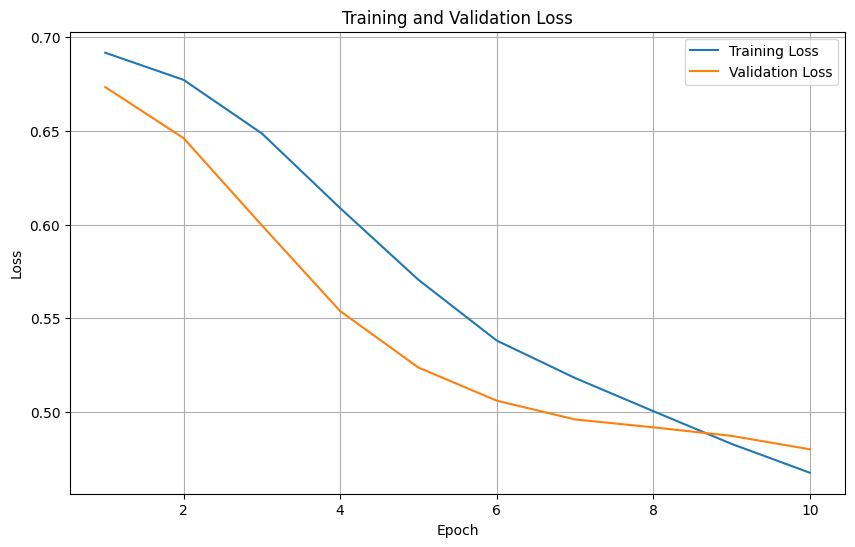

In [10]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2, hidden_dropout_prob=0.3)

tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom pruning function
def custom_prune_model(model, amount=0.2):
    for name, module in model.named_modules(): # function returns an iterator over all the modules (layers) in the model along with their names.
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            num_params = weight.numel()
            num_to_prune = int(amount * num_params)

            # Get the indices of the smallest absolute values
            _, indices = torch.topk(torch.abs(weight).flatten(), k=num_to_prune, largest=False)

            # Create a mask
            mask = torch.ones_like(weight).flatten()
            mask[indices] = 0
            mask = mask.reshape(weight.shape)

            # Apply the mask
            module.weight.data.mul_(mask)

# Prune the model
custom_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#Weight decay:optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
Training Loss: 0.6894
Validation Loss: 0.6507
-----------------------------
Epoch 2/10
Training Loss: 0.6265
Validation Loss: 0.5452
-----------------------------
Epoch 3/10
Training Loss: 0.5570
Validation Loss: 0.4968
-----------------------------
Epoch 4/10
Training Loss: 0.4936
Validation Loss: 0.4782
-----------------------------
Epoch 5/10
Training Loss: 0.4549
Validation Loss: 0.4806
-----------------------------
Epoch 6/10
Training Loss: 0.4182
Validation Loss: 0.4712
-----------------------------
Epoch 7/10
Training Loss: 0.3850
Validation Loss: 0.4749
-----------------------------
Epoch 8/10
Training Loss: 0.3537
Validation Loss: 0.4986
-----------------------------
Epoch 9/10
Training Loss: 0.3332
Validation Loss: 0.4890
-----------------------------
Epoch 10/10
Training Loss: 0.2991
Validation Loss: 0.4985
-----------------------------
Training completed!
Test Accuracy: 79.17%


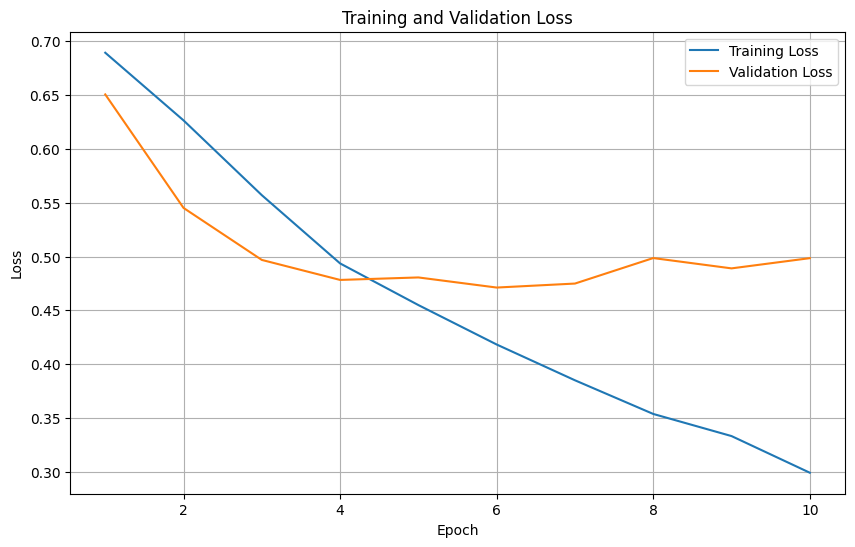

In [11]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2, hidden_dropout_prob=0.3)

tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom pruning function
def custom_prune_model(model, amount=0.2):
    for name, module in model.named_modules(): # function returns an iterator over all the modules (layers) in the model along with their names.
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            num_params = weight.numel()
            num_to_prune = int(amount * num_params)

            # Get the indices of the smallest absolute values
            _, indices = torch.topk(torch.abs(weight).flatten(), k=num_to_prune, largest=False)

            # Create a mask
            mask = torch.ones_like(weight).flatten()
            mask[indices] = 0
            mask = mask.reshape(weight.shape)

            # Apply the mask
            module.weight.data.mul_(mask)

# Prune the model
custom_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 10

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#Learnng rate decrese and weight decay

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Training Loss: 0.6876
Validation Loss: 0.6628
-----------------------------
Epoch 2/10
Training Loss: 0.6668
Validation Loss: 0.6299
-----------------------------
Epoch 3/10
Training Loss: 0.6385
Validation Loss: 0.5895
-----------------------------
Epoch 4/10
Training Loss: 0.6037
Validation Loss: 0.5560
-----------------------------
Epoch 5/10
Training Loss: 0.5618
Validation Loss: 0.5322
-----------------------------
Epoch 6/10
Training Loss: 0.5424
Validation Loss: 0.5158
-----------------------------
Epoch 7/10
Training Loss: 0.5233
Validation Loss: 0.5055
-----------------------------
Epoch 8/10
Training Loss: 0.5009
Validation Loss: 0.5019
-----------------------------
Epoch 9/10
Training Loss: 0.4899
Validation Loss: 0.4949
-----------------------------
Epoch 10/10
Training Loss: 0.4672
Validation Loss: 0.4890
-----------------------------
Training completed!
Test Accuracy: 76.83%


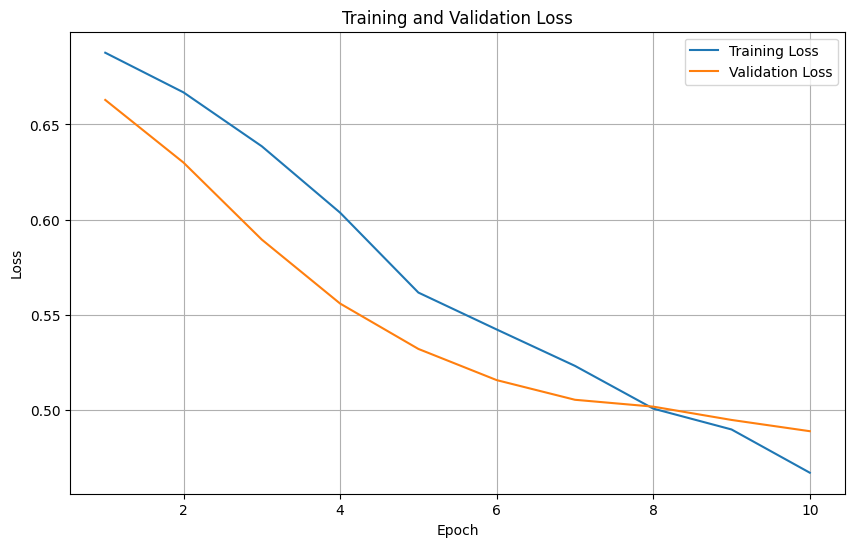

In [14]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2, hidden_dropout_prob=0.3)

tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom pruning function
def custom_prune_model(model, amount=0.1):
    for name, module in model.named_modules(): # function returns an iterator over all the modules (layers) in the model along with their names.
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            num_params = weight.numel()
            num_to_prune = int(amount * num_params)

            # Get the indices of the smallest absolute values
            _, indices = torch.topk(torch.abs(weight).flatten(), k=num_to_prune, largest=False)

            # Create a mask
            mask = torch.ones_like(weight).flatten()
            mask[indices] = 0
            mask = mask.reshape(weight.shape)

            # Apply the mask
            module.weight.data.mul_(mask)

# Prune the model
custom_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 10

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Epoch 1/3
Training Loss: 0.3918
Validation Loss: 0.3579
-----------------------------
Epoch 2/3
Training Loss: 0.1806
Validation Loss: 0.4631
-----------------------------
Epoch 3/3
Training Loss: 0.0796
Validation Loss: 0.6290
-----------------------------
Training completed!
Test Accuracy: 83.68%


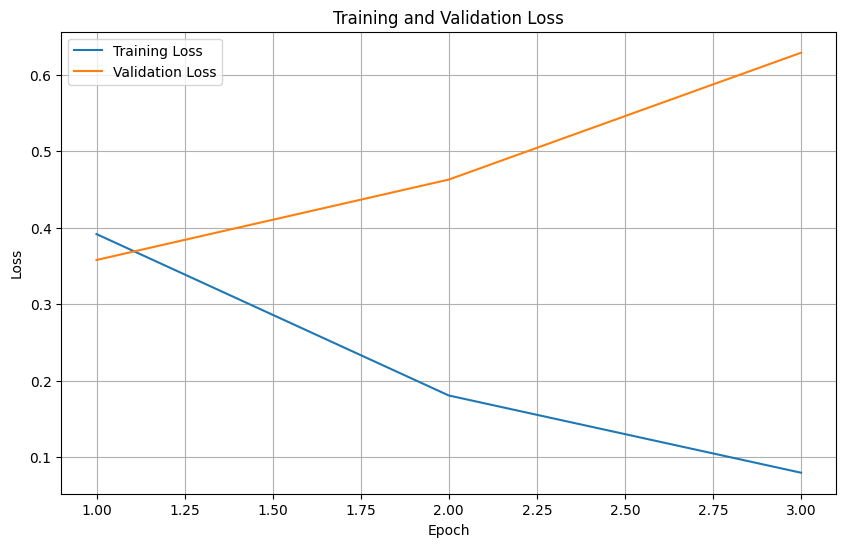

In [15]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load BERT-base-uncased model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size to handle larger model
test_dataloader = DataLoader(test_dataset, batch_size=16)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)  # Reduced learning rate for BERT-base
num_epochs = 3  # Reduced number of epochs to prevent overfitting

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training Loss: 0.3876
Validation Loss: 0.3581
-----------------------------
Epoch 2/5
Training Loss: 0.1676
Validation Loss: 0.4344
-----------------------------
Epoch 3/5
Training Loss: 0.0560
Validation Loss: 0.5523
-----------------------------
Epoch 4/5
Training Loss: 0.0189
Validation Loss: 0.5968
-----------------------------
Epoch 5/5
Training Loss: 0.0067
Validation Loss: 0.7135
-----------------------------
Training completed!
Test Accuracy: 85.83%


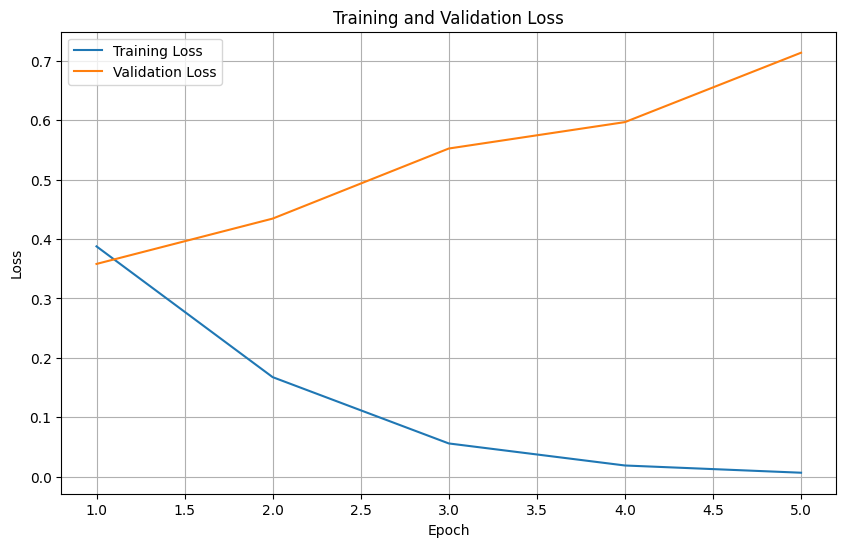

In [16]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from transformers import get_scheduler
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load BERT-base-uncased model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Increased batch size
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use AdamW optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)  # Increased learning rate slightly

# Create a learning rate scheduler
num_epochs = 5  # Increased number of epochs
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Step the scheduler
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
Training Loss: 0.4288
Validation Loss: 0.3651
-----------------------------
Epoch 2/5
Training Loss: 0.2811
Validation Loss: 0.4089
-----------------------------
Epoch 3/5
Training Loss: 0.1927
Validation Loss: 0.4298
-----------------------------
Early stopping triggered
Training completed!
Test Accuracy: 84.62%


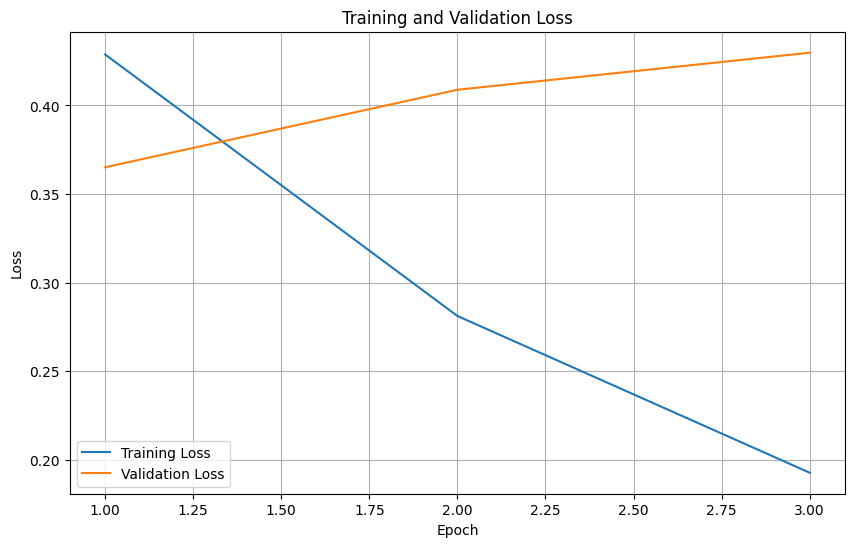

In [17]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from transformers import get_scheduler
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load BERT-base-uncased model and tokenizer with increased dropout
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2,
                                                      hidden_dropout_prob=0.3)  # Increased dropout
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Use AdamW optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)  # Added weight decay

# Create a learning rate scheduler
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Step the scheduler
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter if we have a new best
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
# Install required libraries
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load TinyBERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2, hidden_dropout_prob=0.3)
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")

# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Tokenize and prepare the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' to match model expectations
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Custom L1 pruning function
def l1_prune_model(model, amount=0.2):
    """Prune the model using L1 norm."""
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            weight = module.weight.data
            l1_norm = weight.abs().sum(dim=1)  # Calculate L1 norm
            threshold = torch.topk(l1_norm, int(amount * len(weight)), largest=False).values[-1]  # Get threshold

            # Create a mask
            mask = l1_norm > threshold
            module.weight.data.mul_(mask.float())  # Apply the mask

# Prune the model
l1_prune_model(model)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

# Lists to store losses for plotting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("-----------------------------")

print("Training completed!")

# Evaluate accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        _, predicted = torch.max(outputs.logits, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

RuntimeError: The size of tensor a (128) must match the size of tensor b (512) at non-singleton dimension 1